# Normals and other local descriptors

This notebook tackles the computation of normals and other local descriptors or features, which provide **additional information about the underlying surface geometry around each point**. These local descriptors play a crucial role in various tasks such as rendering, surface reconstruction, segmentation, and classification. The quality of their estimation greatly impacts the quality and reliability of subsequent processing steps.

In this notebook, we will delve into the methods and techniques for computing normals, curvatures and other local descriptors. The emphasis placed on calculating normals is the result of their widespread use in point cloud processing. We will explore various algorithms, discuss their strengths and limitations, and provide practical examples to illustrate their application.

In [1]:
# Necessary imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import KDTree, Delaunay
from scipy.sparse import dok_matrix
from scipy.sparse.csgraph import minimum_spanning_tree, breadth_first_order

# Load example pointcloud
data = np.loadtxt("./data/stanford_bunny_custom.xyz")
points = data[:, :3]
ground_truth_normals = data[:, 3:6]

# Build KDTree for neighbor search
kdtree = KDTree(points)


## Normals

**A normal is a vector associated with each point of a pointcloud and perpendicular to the underlying surface it samples**. The convention is that the normal **points outward from the surface**. In some cases, normals are calculated directly during the acquisition process. In most cases, they must be computed afterwards, which is what is considered here.

The most common technique for calculating normals is based on the *tangent plane estimation*, which simply involves **approximating the underlying surface around each point by a plane**. In practice, a plane is fitted to the set of points consisting of the point of interest and its closest neighbors. The normal to the point is approximated by the normal to the fitted plane. This approach was described in the widely cited article:

Hoppe, H., et al. (1992, July). Surface reconstruction from unorganized points. In *Proceedings of the 19th annual conference on computer graphics and interactive techniques* (pp. 71-78).

It may be summarized in a few steps.

For each point $p_i$ of the pointcloud:
1. Query the $k$-nearest neighbors of $p_i$ and add them to a set $N_b(p_i)$ also containing $p_i$.
2. Compute the inertia matrix $I_{i}$ from this set.
3. Decompose the inertia matrix $I_i$ into eigenvalues $(\lambda_1, \lambda_2, \lambda_3)$ and eigenvectors $(\nu_1, \nu_2, \nu_3)$.
4. Select **the normal as the eigenvector associated with the smallest eigenvalue**, or to put it simply: $n_i \pm \nu_3$.

As a reminder (see last chapter on primitive fitting for more details), the inertia matrix of the neighbors is given by $I_i = \sum_{p_{j} \in N_b(p_{i})} (p_j - c_i) \cdot (p_j - c_i)^{T}$ with $c_{i}$ the center of mass of the set of neighbors $N_b(p_i)$, given by $c_{i} = \frac{1}{k+1} \sum_{p_{j} \in N_b(p_{i})} p_j$. The fitting process is here considered in the sense of least squares, and the fitting error is given directly by $\lambda_3$.

Let's see the result on our *Stanford Bunny*!

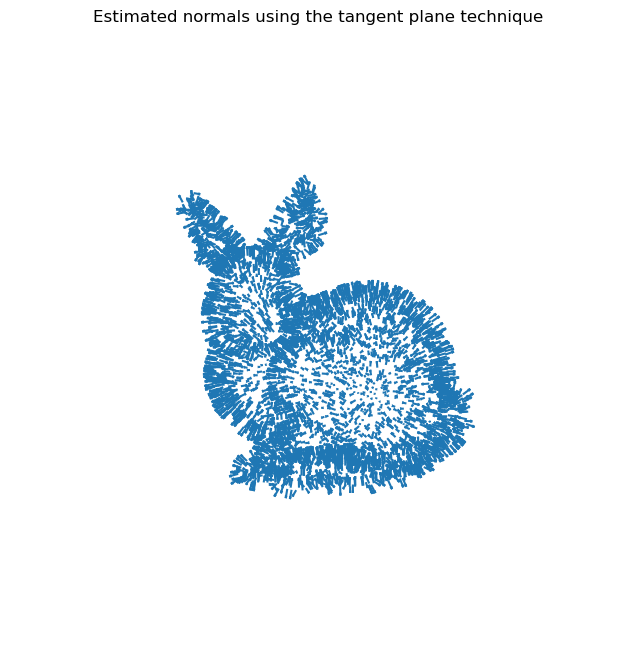

In [2]:
def compute_normals(points, neighbor_finding_function):
    
    # Initialize an array to hold the normals
    normals = np.zeros(points.shape)
    
    for i, point in enumerate(points):
        # Find the k nearest neighbors
        indices = neighbor_finding_function(point)
        # Get the neighbors
        neighbors = points[indices]
        # Compute the covariance matrix
        cov_matrix = np.cov(neighbors.T)
        # Compute the eigenvalues and eigenvectors
        _, eigenvectors = np.linalg.eigh(cov_matrix)
        # The normal is the eigenvector corresponding to the smallest eigenvalue
        normals[i] = eigenvectors[:, 0]
    
    return normals


# Define neighbor finding function using KDTree
def neighbor_finding_function(point): return kdtree.query(point, k=10)[1]
# Compute normals
normals = compute_normals(points, neighbor_finding_function)

# Visualize the point cloud and normals
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.quiver(points[:, 0], points[:, 1], points[:, 2],
        5.*normals[:, 0], 5.*normals[:, 1], 5.*normals[:, 2]) # we make normals a little bit larger for visualization purposes
ax.view_init(10, 60)
ax.set_axis_off()
plt.axis("equal")
plt.title("Estimated normals using the tangent plane technique")
plt.show()


The process of estimating the normals seems to have gone well, and the overall result is quite visually convincing. However, this is not the case when zooming in on certain areas, as can be seen below where the estimated normals are compared with the ground truth normals (derived from the original bunny mesh).


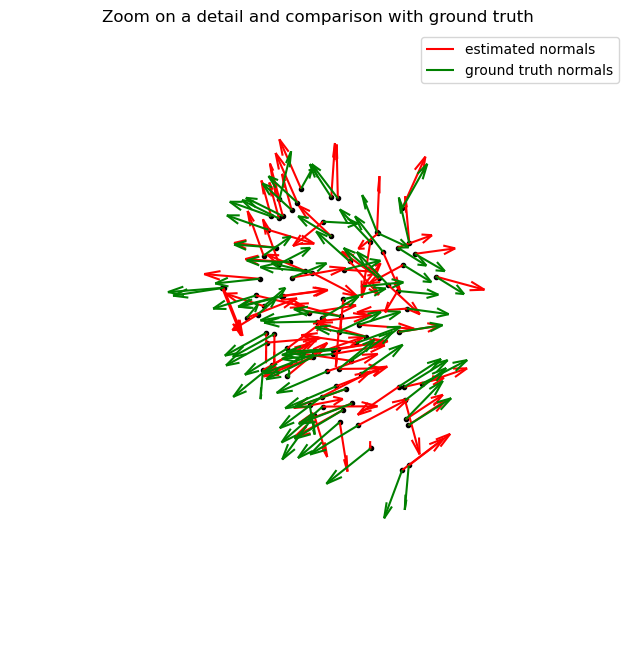

In [3]:
# Zoom on a detail (rabbit ear) and compare with ground truth normals
inds_detail = kdtree.query_ball_point(points[136], r=25.)

# Visualize the sub pointcloud and normals
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2], 'k.')
ax.quiver(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2],
        normals[inds_detail, 0], normals[inds_detail, 1], normals[inds_detail, 2], 
        length=5., # we make normals a little bit larger for visualization purposes
        color="red", label="estimated normals") 
ax.quiver(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2],
        ground_truth_normals[inds_detail, 0], ground_truth_normals[inds_detail, 1], ground_truth_normals[inds_detail, 2], 
        length=5.0, # we make normals a little bit larger for visualization purposes
        color="green", label="ground truth normals")
ax.view_init(0, 0)
ax.set_axis_off()
ax.legend()
plt.axis("equal")
plt.title("Zoom on a detail and comparison with ground truth")
plt.show()

One source of error can be attributed to the *tangent plane approximation* itself, which degree of validity depends on the considered scale. In practical terms, the choice of the type and size of the neighborhood plays significant role in normal computation. Indeed, small neighborhoods better capture the underlying local surface around a point but makes the best-fit plane computation sensitive to noise. On the other hand, large neighborhoods are less likely to capture the surface variation around the point but tend to reduce the contribution of noise in the computation of the best-fit plane. Moreover, this trade-off applies to each individual point, based on local pointcloud density and noise.

The residual of the best-fitted plane, given by the smallest eigenvalue $\lambda_3$, is a good indicator to assess the locally-plane surface hypothesis (see last notebook on primitive fitting). Its value may for example be compared to acquisition noise or to other values obtained with different neighborhoods. Another option is to use metric to assess that the tangent plane hypothesis is verified. Once again, eigenvalues may be put to good use. The tangent plane hypothesis is verified if $\lambda_1 \geq \lambda_2 >> \lambda_3$. So, in practice, the ratio between the smallest eigenvalue and the others may be a suitable indicator to choose the appropriate type and size of neighborhood to compute normals:
\begin{equation*}
r = \frac{\lambda_3}{\lambda_1 + \lambda_2}
\end{equation*}

The rule of thumb is that the denser the pointcloud, the larger the number of neighbors $k$ (knn search) or the radius $r$ (ball search) used to compute the tangent plane. Usually, a value of $k=10$ is a good starting point. It may then be refined for the whole pointcloud or specific zones of it.

Below are some results obtained for our bunny. As expected, the tangent plane hypothesis is least verified for the zone of high surface variation such as the ears of the rabbit. A small $k$ value is better suited for a small pointcloud such as this one.

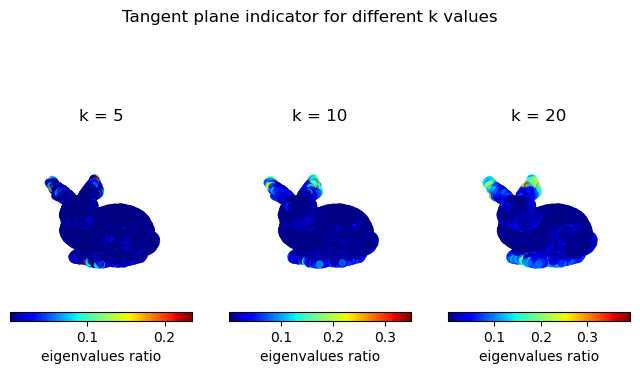

In [4]:
def compute_normals_with_ratio(points, neighbor_finding_function):
    
    # Initialize an array to hold the normals
    normals = np.zeros(points.shape)
    ratio = np.zeros(points.shape[0])
    
    for i, point in enumerate(points):
        # Find the k nearest neighbors
        indices = neighbor_finding_function(point)
        # Get the neighbors
        neighbors = points[indices]
        # Compute the covariance matrix
        cov_matrix = np.cov(neighbors.T)
        # Compute the eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        # The normal is the eigenvector corresponding to the smallest eigenvalue
        normals[i] = eigenvectors[:, 0]
        # Compute the ratio of the smallest eigenvalue to the sum of the other two
        ratio[i] = eigenvalues[0] / (eigenvalues[1] + eigenvalues[2])
    
    return normals, ratio


# Compute normals and ratio for different k values
k_neighbors = [5, 10, 20]
ratios = []
for k in k_neighbors:
    # Define neighbor finding function using KDTree
    def neighbor_finding_function(point, k=k): return kdtree.query(point, k=k)[1]
    # Compute normals and ratio
    _, ratio = compute_normals_with_ratio(points, neighbor_finding_function)
    ratios.append(ratio)

# Visualize the ratio for different k values
fig = plt.figure(figsize=(8, 4))
for i, ratio in enumerate(ratios):
    ax = fig.add_subplot(1, len(ratios), i+1, projection="3d")
    im = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=ratio, cmap='jet')
    cbar = fig.colorbar(im, ax=ax, location="bottom", orientation="horizontal", pad=0)
    cbar.set_label('eigenvalues ratio')
    ax.set_title(f"k = {k_neighbors[i]}")
    ax.view_init(10, 60)
    ax.set_axis_off()
plt.suptitle("Tangent plane indicator for different k values")
plt.show()


Another source of error is attributed to the lack of *consistent orientation* between the estimated tangent planes. Indeed, the local plane approximation described above does not guarantee that all computed normals point outward from the surfaces describing our bunny. Some may instead point to the opposite direction (i.e., inward), as illustrated above.

To solve this, the authors of the paper cited above consider that the pointcloud is sufficiently dense and the underlying surface sufficiently smooth so that **tangent planes computed for two close points $p_i$ and $p_j$ are nearly parallel** so $n_i \cdot n_j \approx \pm 1$. Therefore, the following criterion for orientation consistency is defined: **if $n_i \cdot n_j > O$ then normals are consistently aligned**. If not, one of them should be flipped. The next step is to find pairs of "close" points with nearly parallel tangent planes along which to check for validity and make corrections if necessary. This is done by **finding a path through neighboring points minimizing variation between normals, thanks to elements of graph theory**. More precisely, this path is the *minimum spanning tree* of the *Riemannian Graph*, which edges connect close points and are weighted according to the angle between unoriented normals. Finally, a starting point is selected and the graph is traversed, flipping normals when necessary.

In short, consistent tangent plane orientation is computed as follows:

1. Compute the Euclidean Minimum Spanning Tree (EMST) or the shortest path (distance) connecting all points.
2. Add edges to the EMST to connect each point to its $k$-nearest neighbors to obtain the *Riemannian Graph*.
3. Replace/compute the weights associated with edges of the *Riemannian Graph* such as $e_{ij} = 1 - |n_i \cdot n_j|$.
4. Extract the minimum spanning tree of the *Riemannian Graph*.
5. Choose an initial point and orientation, for example select the point with the highest $z$ coordinate and make it pointing towards $+z$ (so that $n_0 \cdot e_z > 0$).
6. Traverse the graph, flipping the normal $n_j$ if $n_i \cdot n_j < 0$.

Note that the EMST described above happens to be a subgraph of the Delaunay triangulation, so computing the Delaunay Triangulation is an efficient way to get the EMST.

The implementation proposed below mostly relies on ```scipy``` routines for the "heavy lifting" (i.e., nearest neighbors search, Delaunay triangulation, minimum spanning tree and tree traversal). Graphs are represented as 2D sparse matrices (for more efficient memory management) with a value in position $(i, j)$ denoting an edge $e_{ij}$ between vertices $v_i$ and $v_j$ associated with a weight given by this value.

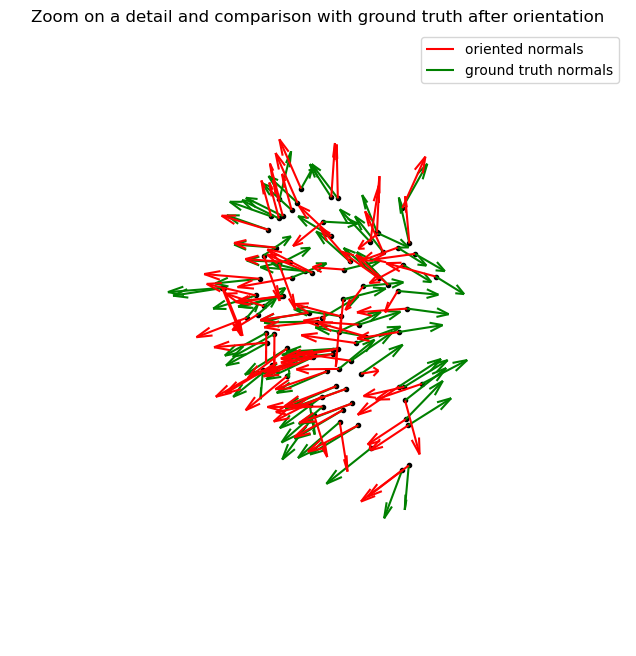

In [5]:
def orient_normals(points, normals, neighbor_finding_function):
    """Orient normals using a Riemannian Minimum Spanning Tree (RMST) approach."""
    
    normals = normals.copy()

    # Create graph (adjacency matrix)
    n_points = len(points)
    riemannian_graph = dok_matrix((n_points, n_points), dtype=np.float32)

    # Compute the Euclidean graph using Delaunay triangulation
    tri = Delaunay(points)
    indptr, indices = tri.vertex_neighbor_vertices
    for i in range(n_points) :
        neighbors = indices[indptr[i]:indptr[i+1]]
        dists = np.linalg.norm(points[i] - points[neighbors], axis=1)
        riemannian_graph[k, neighbors] = dists
    
    # Compute the minimum spanning tree of the Euclidean graph (EMST)
    riemannian_graph = minimum_spanning_tree(riemannian_graph, overwrite=True)
    riemannian_graph = riemannian_graph.todok() # Convert back to DOK format for faster manipulation

    # Add k-nearest neighbors to the EMST to get a denser graph called the Riemannian graph
    neighbors = neighbor_finding_function(points) # k+1 because the point itself is included
    neighbors = neighbors[:, 1:] # Remove the point itself
    for i, nbrs in enumerate(neighbors):
        riemannian_graph[i, nbrs] = 1.

    # Weight the edges of the Riemannian graph according to normal similarity
    for (i, j) in riemannian_graph.keys():
        riemannian_graph[i, j] = 1 - np.abs(normals[i] @ normals[j]) + 1e-6

    # Compute the minimum spanning tree of the Reimannian graph
    riemannian_graph = minimum_spanning_tree(riemannian_graph, overwrite=True)

    # Choose the point with the highest z-coordinate as the root and orient its normal upwards
    root_index = np.argmax(points[:, 2])
    if normals[root_index] @ np.array([0, 0, 1]) < 0:
        normals[root_index] *= -1

    # Propagate normals through the MST
    node_array, predecessors = breadth_first_order(riemannian_graph, root_index, directed=False, return_predecessors=True)
    node_array = node_array[1:] # Exclude the root node from processing
    for current in node_array:
        previous = predecessors[current]
        # Ensure normal consistency
        if normals[current] @ normals[previous] < 0:
            normals[current] *= -1 

    return normals


# Orient normals
# here a low k value is adapted given the density of the point cloud
def neighbor_finding_function(point): return kdtree.query(point, k=10)[1]
oriented_normals = orient_normals(points, normals, neighbor_finding_function)

# Visualize the point cloud and normals after orientation
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2], 'k.')
ax.quiver(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2],
        oriented_normals[inds_detail, 0], oriented_normals[inds_detail, 1], oriented_normals[inds_detail, 2],
        length=5., # we make normals a little bit larger for visualization purposes
        color="red", label="oriented normals") 
ax.quiver(points[inds_detail, 0], points[inds_detail, 1], points[inds_detail, 2],
        ground_truth_normals[inds_detail, 0], ground_truth_normals[inds_detail, 1], ground_truth_normals[inds_detail, 2], 
        length=5., # we make normals a little bit larger for visualization purposes
        color="green", label="ground truth normals")
ax.view_init(0, 0)
ax.set_axis_off()
ax.legend()
plt.axis("equal")
plt.title("Zoom on a detail and comparison with ground truth after orientation")
plt.show()


As seen above and below, normals are better oriented now but some deviations still remain. 

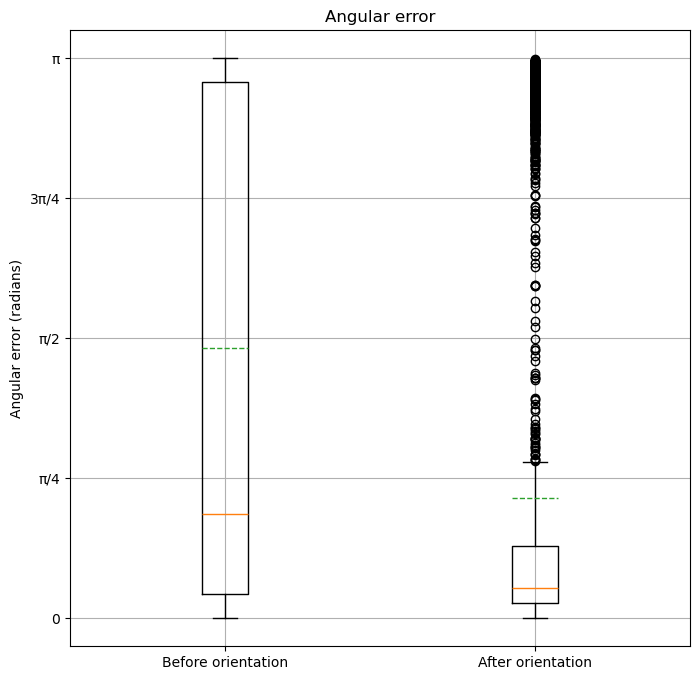

In [6]:
# Plot angular error between estimated normals and ground truth normals
plt.figure(figsize=(8, 8))
plt.boxplot(
    [np.arccos(np.clip(np.sum(n * ground_truth_normals, axis=1), -1.0, 1.0))
    for n in [normals, oriented_normals]], 
    tick_labels=["Before orientation", "After orientation"],
    meanline=True, showmeans=True,
    )
plt.ylabel("Angular error (radians)")
plt.yticks([0., np.pi/4, np.pi/2, 3*np.pi/4, np.pi], ["0", "π/4", "π/2", "3π/4", "π"])
plt.title(f"Angular error")
plt.grid(True)
plt.show()


Although it dates back several decades, the technique described above for calculating and orienting normals is still widely used today (for example in CloudCompare). Despite some limitations due to its initial assumptions, it produces fairly good results while having relatively short execution time, even for large pointclouds.

Note that many variations of this technique and other "tricks" have been proposed since then to mitigate some of its limitations and improve its results. The paragraph below lists a few examples.

Let's start with the tangent plane estimation itself. As we have seen previously, this is based primarily on a locally smooth surface assumption that is rarely verified for the whole pointcloud. To overcome this limitation and better capture the surface variation, some proposed fitting more complex surfaces, such as spheres or quadrics, to each point's neighborhood instead of a plane. This comes, however, with a higher computational cost and sensitivity to noise (these surfaces having more parameters than a plane).

Other propositions of improvement focus on the type of neighborhood used for planar approximation and orientation propagation. Indeed, $k$-nearest neighborhoods or spherical neighborhoods often retain points belonging to other surfaces in areas of high surface variation. This is the case for our bunny's ears, with points belonging to the inside of the ear and points belonging to the outside of it being very close. This is why the implementation of the ```orient_normals_consistent_tangent_plane``` of the ```open3D``` library proposes to use a pseudo-spheric neighborhood penalizing the distance between neighboring points and the tangent plane such as:
\begin{equation*}
    dist(p_i, p_j) = ||p_j - p_i|| + \lambda |(p_j - p_i) \cdot n_i |
\end{equation*}
with $\lambda$ the penalty weight (if null then it falls back to the regular case for which Euclidean distance is considered). An angular threshold is also proposed, in addition to the distance metric described before, to exclude neighbors based on the direction of their normals. However, this requires a good initial approximation of normals.

Lastly, some of the proposed improvements concern the consistent orientation propagation in high variation zones of the pointcloud. Indeed, the original technique is based on a "close-to-parallel-tangent-planes" or null-curvature hypothesis that isn't verified in this case and leads to inconsistently oriented normals. To overcome this problem, a slightly modified edge weighting function (for the Riemannian graph) and flipping criterion is proposed in the article: 

Xie, H., Wang, J., Hua, J., Qin, H., & Kaufman, A. (2003). Piecewise C1 continuous surface reconstruction of noisy point clouds via local implicit quadric regression. In *IEEE Visualization Conference*.

It simply replaces the incident normal $n_i$ with its reflection $n'_i$ along the bisector plane of the segment $e_{ij} = p_i - p_j$. It is defined by:
\begin{equation*}
    n'_i = n_i - \frac{2(e_{ij} \cdot n_i)}{||e_{ij}||^2} e_{ij}
\end{equation*}
This is equivalent to considering that $p_i$ and $p_j$ are on a sphere instead of two parallel planes. Note that the behavior stays the same for the planar case, so the initial algorithm almost doesn't change. This is not the case with some other proposed techniques, which rely on more complex edge weighting functions and flip criteria, whose often modest improvements come with higher implementation and computational costs.

To conclude on a more general note, graph-based techniques are not the only ones found in literature for obtaining consistent normal orientation. Other techniques, based for example on Voronoi diagrams, the Hough transform or RANSAC are also found, although much less commonly used in practice. The most recent advances come from the deep learning community, aided by the emergence of large datasets and benchmarks.

## Curvatures

Curvatures may coarsely be defined in our context as geometric properties describing "how a surface bends in space". These pieces of information are particularly useful for 3D points (again, sampling surfaces of objects) as they provide insights into the local and global shape characteristics. In this context, principal curvatures $(k_{1}, k_{2})$ and Gaussian and mean curvatures $(K, H)$ are often computed. **Principal curvatures are maximum and minimum curvatures at a point on the surface, corresponding to the directions in which the surface bends the most and the least. Gaussian and mean curvatures are respectively the product and the mean of the principal curvatures at this point.** The relationships between principal and Gaussian and mean curvatures are given by:

\begin{equation*}
K = k_{1} . k_{2}~\text{and}~H = (k_{1} + k_{2})/2
\end{equation*}

and 
\begin{equation*}
k_{1}, k_{2} = H \pm \sqrt{H² - K}
\end{equation*}

depending of sign of $K$ and $H$.

Curvatures are, for example, used for classifying and grouping points, but also for detecting surfaces in the pointcloud. The sign of Gaussian curvature $K$ indicates if the surface is locally a bowl, a saddle or just flat, and the of sign mean curvature $H$ indicates its "orientation"(convex, concave or flat). Combining the two gives the classification below. Note that the difference between a ridge/peak and a valley/pit is merely a matter of perspective. Likewise, it is possible to link principal curvatures with primitive shapes.

|       | $K<0$ | $K=0$ | $K>0$ |
|:------|:------|:------|:------|
| $H<0$ | Saddle ridge | Ridge | Peak |
| $H=0$ | Minimal | Plane | (impossible) |
| $H>0$ | Saddle valley | Valley | Pit |

Several techniques have been proposed in the literature for estimating local curvatures, and listing them all here would take too long. One notable and frequently used technique involves **fitting a smooth surface to neighboring points and using results from differential geometry to estimate curvatures**. 

Parametric surfaces are typically used for their ease of manipulation and their capacity to represent or approximate complex shapes. In a 3D space, they express the coordinates of the points on the surface as functions of two parameters such as $r(u, v) = (x(u,v), y(u,v), z(u,v))$.

The process of estimating local curvatures from parametric surfaces involves:
1. Calculating the first and second order partial derivatives with respect to $u$ and $v$

\begin{equation*}
r_u = \frac{\partial r}{\partial u},~r_v = \frac{\partial r}{\partial v},~r_{uv} = \frac{\partial ² r}{\partial u \partial v}~r_{uu} = \frac{\partial ² r}{\partial ² u},~r_{vv} = \frac{\partial ² r}{\partial ² v}
\end{equation*}

2. Calculating the normal
\begin{equation*}
n(u, v) = \frac{r_u \times r_v}{||r_u \times r_v||}
\end{equation*}

3. Determining the first ($I$) and the second ($II$) fundamental forms
\begin{equation*}
I = E du² + 2F du dv + G dv²
\end{equation*}
with $E = r_u \cdot r_u = ||r_u||²$, $F = r_u \cdot r_v$, and $G = r_v \cdot r_v = ||r_v||²$.
\begin{equation*}
II = L du² + 2M du dv + N dv²
\end{equation*}
with $L = r_{uu} \cdot n$, $M = r_{uv} \cdot n$, and $N = r_{vv} \cdot n$.

4. Calculating the Gaussian and Mean curvatures
\begin{equation*}
K = \frac{LM - N²}{EG - F²}
\end{equation*}
 
\begin{equation*}
H = \frac{EN - 2FM + GL}{2(EG - F²)}
\end{equation*}

5. (Optionally) Organizing the fundamental forms coefficients in symmetric matrices $F_1$ and $F_2$ and computing the shape operator $P$
\begin{equation*}
P = F_{1}^{-1} F_{2} = \begin{pmatrix} E & F \\ F & G \end{pmatrix}^{-1} \begin{pmatrix} L & M \\ M & N \end{pmatrix}
\end{equation*}
The principal curvatures $k_1$ and $k_2$ are the eigenvalues of this *shape operator* $P$. The principal vectors associated with principal curvatures are deduced from the eigenvectors $v_1$ and $v_2$
\begin{equation*}
t_1 = v_{11} r_u + v_{12} r_v ~\text{and}~ t_2 = v_{21} r_u + v_{22} r_v
\end{equation*}


The choice of the type of parametric surface used for curvature estimation is potentially broad and many are found in the literature.

One of the simplest types of parametric surface is defined by $r(x, y) = (x, y, g(x,y))$ with $z = g(x, y)$.

The choice of the $g$ function is also large. It must admit second order derivatives while being able to approximate complex surfaces and being quite inexpensive to compute. Polynomial functions of dimension two are typically good candidates as they meet both these theoretical and more practical requirements. These give the biquadric surface equation below:
\begin{equation*}
z = a.x² + b.y² + c.xy + d.x + e.y + f
\end{equation*}

Before going further, let's see how they look like!

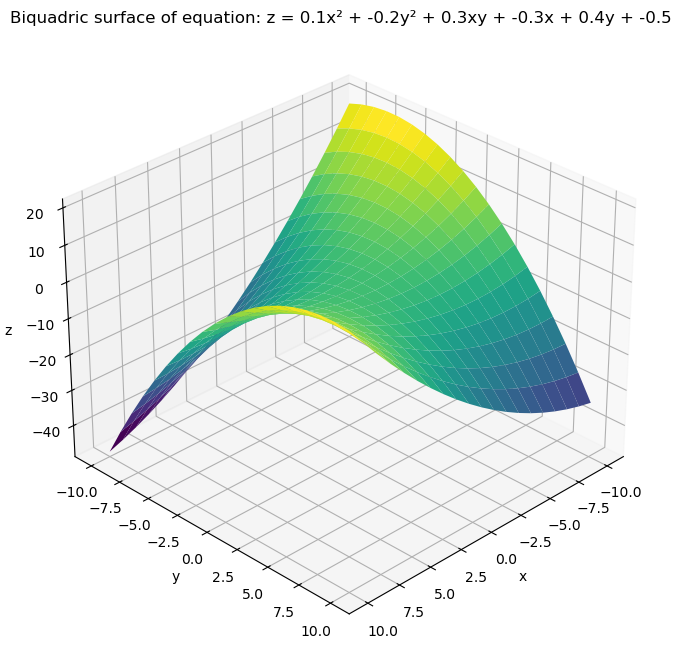

In [7]:
def g(x, y, coeffs):
    """Compute the z values of a biquadric surface of equation:
    z = a.x² + b.y² + c.xy + d.x + e.y + f."""
    
    # biquadric surface equation: z = a.x² + b.y² + c.xy + d.x + e.y + f
    a, b, c, d, e, f = coeffs
    
    return a * x**2 + b * y**2 + c * x * y + d * x + e * y + f


# Define biquadric surface coefficients (a, b, c, d, e, f)
coefficients = [0.1, -0.2, 0.3, -0.3, 0.4, -0.5]
a, b, c, d, e, f = coefficients

# Create a grid of points
x = np.linspace(-10, 10, 20)
y = np.linspace(-10, 10, 20)
X, Y = np.meshgrid(x, y)
Z = g(X, Y, coefficients)

# Plot the surface
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title(f"Biquadric surface of equation: z = {a}x² + {b}y² + {c}xy + {d}x + {e}y + {f}")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(30, 45)
plt.show()


Now let's consider the process of estimating local curvatures described above with the parametric surface described by: $r(x, y) = (x, y, g(x,y))$ with $g(x, y) = a.x² + b.y² + c.xy + d.x + e.y + f$.

The first step is to compute partial derivatives, which are fairly simple with $r_{x} = (1, 0, g_x)$ and $g_x = 2ax + cy + d$, and $r_{y} = (0, 1, g_y)$ and $g_y = 2by + cx + e$, and so on.

Skipping most of the calculation, normals and Gaussian and mean curvatures are finally given for each point on the surface by:

\begin{equation*}
n(x, y) = \frac{1}{\sqrt{g_x² + g_y² + 1}} (-g_x, -g_y, 1)
\end{equation*}

\begin{equation*}
K(x, y) = \frac{4ab - c²}{(g_x² + g_y² + 1)^{3/2}}
\end{equation*}

\begin{equation*}
H(x, y) = \frac{a(1 + g_y²) + b(1 + g_x²) - cg_{x}g_{y}}{(g_x² + g_y² + 1)^{3/2}}
\end{equation*}

Let's see how it looks for our surface!

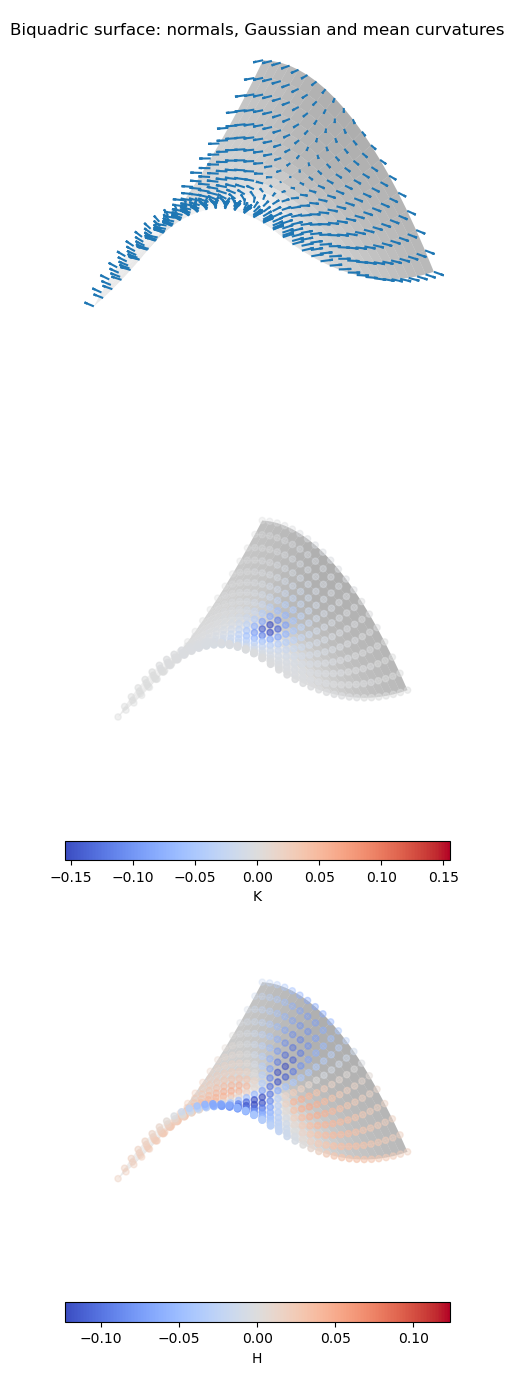

In [8]:
def g_x(x, y, coeffs):
    """Partial derivative of the biquadric surface with respect to x."""
    
    a, _, c, d, _, _ = coeffs
    
    return 2*a*x + c*y + d

def g_y(x, y, coeffs):
    """Partial derivative of the biquadric surface with respect to y."""

    _, b, c, _, e, _ = coeffs
    
    return 2*b*y + c*x + e

def n_biquadric(x, y, coeffs):
    """Compute the normal vector at point (x, y) on the biquadric surface."""
    
    gx = g_x(x, y, coeffs)
    gy = g_y(x, y, coeffs)
    normal = np.array([-gx, -gy, 1.])
    normal /= np.linalg.norm(normal)
    
    return normal

def K_biquadric(x, y, coeffs):
    """Compute the Gaussian curvature at point (x, y) on the biquadric surface."""
    
    a, b, c, _, _, _ = coeffs
    K = (4*a*b - c**2) / (1 + g_x(x, y, coeffs)**2 + g_y(x, y, coeffs)**2)**(3/2)
    
    return K

def H_biquadric(x, y, coeffs):
    """Compute the Mean curvature at point (x, y) on the biquadric surface."""
    
    a, b, c, _, _, _ = coeffs
    H = (b*(1 + g_x(x, y, coeffs)**2) + a*(1 + g_y(x, y, coeffs)**2) - g_x(x, y, coeffs)*g_y(x, y, coeffs)*c)
    H = H / ((1 + g_x(x, y, coeffs)**2 + g_y(x, y, coeffs)**2)**(3/2))

    return H


# Compute normals on the grid
normals_grid = np.zeros(X.shape + (3,))
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        normals_grid[i, j] = n_biquadric(X[i, j], Y[i, j], coefficients)

# Compute curvature values on the grid
K_values = K_biquadric(X, Y, coefficients)
H_values = H_biquadric(X, Y, coefficients)

# Plot the surface with normals and curvature values
fig = plt.figure(figsize=(8, 14))
ax1 = fig.add_subplot(3, 1, 1, projection='3d')
ax2 = fig.add_subplot(3, 1, 2, projection='3d')
ax3 = fig.add_subplot(3, 1, 3, projection='3d')
# Normals plot
ax1.plot_surface(X, Y, Z, alpha=0.5, color="white")
p1 = ax1.quiver(X, Y, Z, normals_grid[:, :, 0], normals_grid[:, :, 1], normals_grid[:, :, 2])
ax1.set_axis_off()
ax1.view_init(30, 45)
# Gaussian curvature plot
ax2.plot_surface(X, Y, Z, alpha=0.5, color="white")
p2 = ax2.scatter3D(X, Y, Z, c=K_values, cmap='coolwarm', 
                   norm=matplotlib.colors.CenteredNorm()) # to have zero in the middle of the colormap
cbar2 = fig.colorbar(p2, shrink=0.5, location="bottom", orientation="horizontal", pad=0)
cbar2.set_label('K')
ax2.set_axis_off()
ax2.view_init(30, 45)
# Mean curvature plot
ax3.plot_surface(X, Y, Z, alpha=0.5, color="white")
p3 = ax3.scatter3D(X, Y, Z, c=H_values, cmap='coolwarm',
                   norm=matplotlib.colors.CenteredNorm()) # to have zero in the middle of the colormap
cbar3 = fig.colorbar(p3, shrink=0.5, location="bottom", orientation="horizontal", pad=0)
cbar3.set_label('H')
ax3.set_axis_off()
ax3.view_init(30, 45)
plt.tight_layout()
plt.suptitle("Biquadric surface: normals, Gaussian and mean curvatures")
plt.show()


In practice, normals and curvatures do not need to be estimated at every point on the surface, but only at the one corresponding to the position of the point (of the pointcloud) of interest. This point usually corresponds to the origin in the surface local coordinate system, after the fitting process. This has the advantage of greatly simplifying the equations described above, ultimately resulting in

\begin{equation*}
n_0 = \frac{1}{\sqrt{d² + e² + 1}} (-d, -e, 1)
\end{equation*}

\begin{equation*}
K_0 = \frac{4ab - c²}{(d² + e² + 1)^{3/2}}
\end{equation*}

\begin{equation*}
H_0 = \frac{a(1 + e²) + b(1 + d²) - cde}{(d² + e² + 1)^{3/2}}
\end{equation*}

\begin{equation*}
P_0 = \frac{1}{\sqrt{1 + d^2 + c^2}} \begin{pmatrix} 1 + d^2 & de \\ de & 1 + e^2 \end{pmatrix}^{-1} \begin{pmatrix} 2a & c \\ c & 2b \end{pmatrix}
\end{equation*}

Below the result of these computations for our surface. We can observe that directions $t_1$ and $t_2$ corresponding to $k_1$ and $k_2$ are orthogonal.

Note that for most practical applications, only the Gaussian and mean curvatures $K_0$ and $H_0$ are computed. Indeed, these are fast to compute, and their values theoretically do not depend on the local coordinate system considered (only the orientation of the normal has an influence on the sign of $H_0$).

Normal vector at (0, 0): [ 0.26832816 -0.35777088  0.89442719], same as previous: True
Gaussian curvature at (0, 0): K = -0.12164209797598856, same as previous: True
Mean curvature at (0, 0): H = -0.04722575568479556, same as previous: True
***
Gaussian curvature at (0, 0) from principal curvatures: K = -0.10879999999999994
Verifying with direct computation: K = -0.12164209797598856
Mean curvature at (0, 0) from principal curvatures: H = -0.047225755684795534
Verifying with direct computation: H = -0.04722575568479556


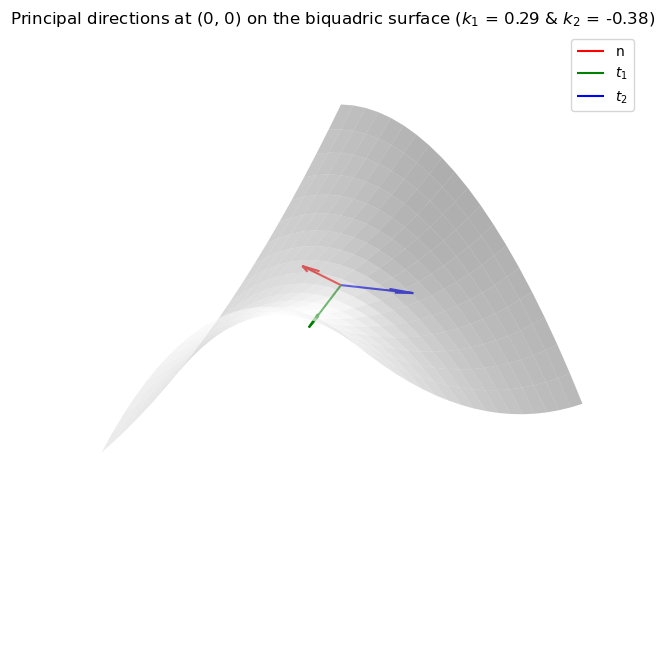

In [9]:
def compute_principal_curvatures(coeffs):
    """Compute the principal curvatures k_1 and k_2 and directions t_1 and t_2 
    at point (0, 0) on the biquadric surface."""
    
    a, b, c, d, e, _ = coeffs
    # Fundamental forms at (0, 0)
    F_1 = np.array([
        [1 + d**2, d*e], 
        [d*e, 1 + e**2]
    ])
    F_2 = np.array([
        [2*a, c],
        [c, 2*b]
    ])
    F_2 /= np.sqrt(1 + d**2 + e**2)
    # Shape operator
    P_0 = np.linalg.inv(F_1) @ F_2
    # Principal curvatures
    eigenvalues, eigenvectors = np.linalg.eig(P_0)
    k_1, k_2 = eigenvalues
    v_1, v_2 = eigenvectors[:, 0], eigenvectors[:, 1]
    # Principal directions in 3D
    t_1 = v_1[0] * np.array([1, 0, d]) + v_1[1] * np.array([0, 1, e])
    t_1 /= np.linalg.norm(t_1)
    t_2 = v_2[0] * np.array([1, 0, d]) + v_2[1] * np.array([0, 1, e])
    t_2 /= np.linalg.norm(t_2)
    
    return k_1, k_2, t_1, t_2


# Analytical values at the origin (0, 0)
n_0 = np.array([-d, -e, 1.]) / np.linalg.norm(np.array([-d, -e, 1.]))
K_0 = (4*a*b - c**2) / (1 + d**2 + e**2)**(3/2)
H_0 = (a*(1 + e**2) + b*(1 + d**2) - c*d*e) / (1 + d**2 + e**2)**(3/2)

# Check that results are the same that previous computations 
print(f"Normal vector at (0, 0): {n_0}, same as previous: {np.allclose(n_0, n_biquadric(0, 0, coefficients))}")
print(f"Gaussian curvature at (0, 0): K = {K_0}, same as previous: {np.isclose(K_0, K_biquadric(0, 0, coefficients))}")
print(f"Mean curvature at (0, 0): H = {H_0}, same as previous: {np.isclose(H_0, H_biquadric(0, 0, coefficients))}")

# Compute principal curvatures and directions at the point (0, 0)
k_1, k_2, t_1, t_2 = compute_principal_curvatures(coefficients)

print("***")
print(f"Gaussian curvature at (0, 0) from principal curvatures: K = {k_1 * k_2}")
print(f"Verifying with direct computation: K = {K_0}")
print(f"Mean curvature at (0, 0) from principal curvatures: H = {(k_1 + k_2) / 2}")
print(f"Verifying with direct computation: H = {H_0}")

# Plot principal directions on the surface
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.5, color="white")
# Normal at (0, 0)
ax.quiver(0, 0, g(0, 0, coefficients), n_0[0], n_0[1], n_0[2], color='red', length=5., label='n')
# Principal directions at (0, 0)
ax.quiver(0, 0, g(0, 0, coefficients), t_1[0], t_1[1], t_1[2], color='green', length=5., label='$t_1$')
ax.quiver(0, 0, g(0, 0, coefficients), t_2[0], t_2[1], t_2[2], color='blue', length=5., label='$t_2$')
ax.set_title(f"Principal directions at (0, 0) on the biquadric surface ($k_1$ = {k_1:.2f} & $k_2$ = {k_2:.2f})")
ax.set_axis_off()
ax.view_init(30, 45)
ax.legend()
plt.show()


Note that a prerequisite for the curvature estimation method described above is the fitting of the surface to a given set of points. This can be done by considering the local plane used to estimate normals, as described in last section about normals computation and orientation. A change of reference is performed so that the origin of the local coordinate system corresponds to the point of interest and its directions to the principal axis. Again, the size of the neighborhood has a great influence on the result of the values of the estimated curvatures.

In summary, curvatures convey a great deal of information about the sampled surfaces. They have the advantage of being invariant to translations and rotations. However, their computation through fitting a biquadric surface to 3D points is quite computationally intensive and sensitive to noise and local density. Note that alternative techniques exist in the literature, the most recent being based on deep learning.

## 3D & 2D point features

While the computation of normals and curvatures described before tries to approximate the local properties of sampled surfaces in space, there is another type of descriptor, called *point features*, that are designed to capture relevant information for specific tasks. These features often leverage geometric properties but not necessarily focusing on the detailed mathematical descriptions provided by differential geometry. These are specifically used in *3D scene analysis* (mainly indoor, urban and natural scenes) and related machine learning tasks.

A remarkable summary and study of these descriptors can be found in:

Weinmann, M., Jutzi, B., Hinz, S., & Mallet, C. (2015). Semantic point cloud interpretation based on optimal neighborhoods, relevant features and efficient classifiers. *ISPRS Journal of Photogrammetry and Remote Sensing*, 105, 286-304.

The following paragraphs cover the features listed in this work.


### Geometric 3D properties

Radius of k-Nearest Neighbors: $r_{knn} = \max_{p_j \in N_{k}(p_i)} d(p_i, p_j)$ which is the distance to the $k$-th nearest neighbor.

Density: $D = (k+1)/(\frac{4}{3} \pi r^3) $ with $r$ is the radius of the local neighborhood.

Verticality: $ V = 1 - |n_{z}| $ with $n_z$ is the z-component of the normal vector.

The maximum difference of height values: $ \Delta_{z} = \max(Z_{\text{neighbors}}) - \min(Z_{\text{neighbors}}) $

The standard Deviation of height values: $ \sigma_{z} = \sqrt{\frac{1}{k} \sum{j=1}^{k} (Z_j - \bar{Z})^2} $

In [10]:
# Load example pointcloud
data = np.loadtxt("./data/indoor_scene_v2.xyz")
points = data[:, :3]

# Build KDTree for neighbor search
kdtree = KDTree(points)

# k parameter for neighbor search
k = 12

# Compute normals
neighbor_finding_function = lambda point: kdtree.query(point, k+1)[1] # +1 because the point itself is included
normals = compute_normals(points, neighbor_finding_function)
oriented_normals = orient_normals(points, normals, neighbor_finding_function)


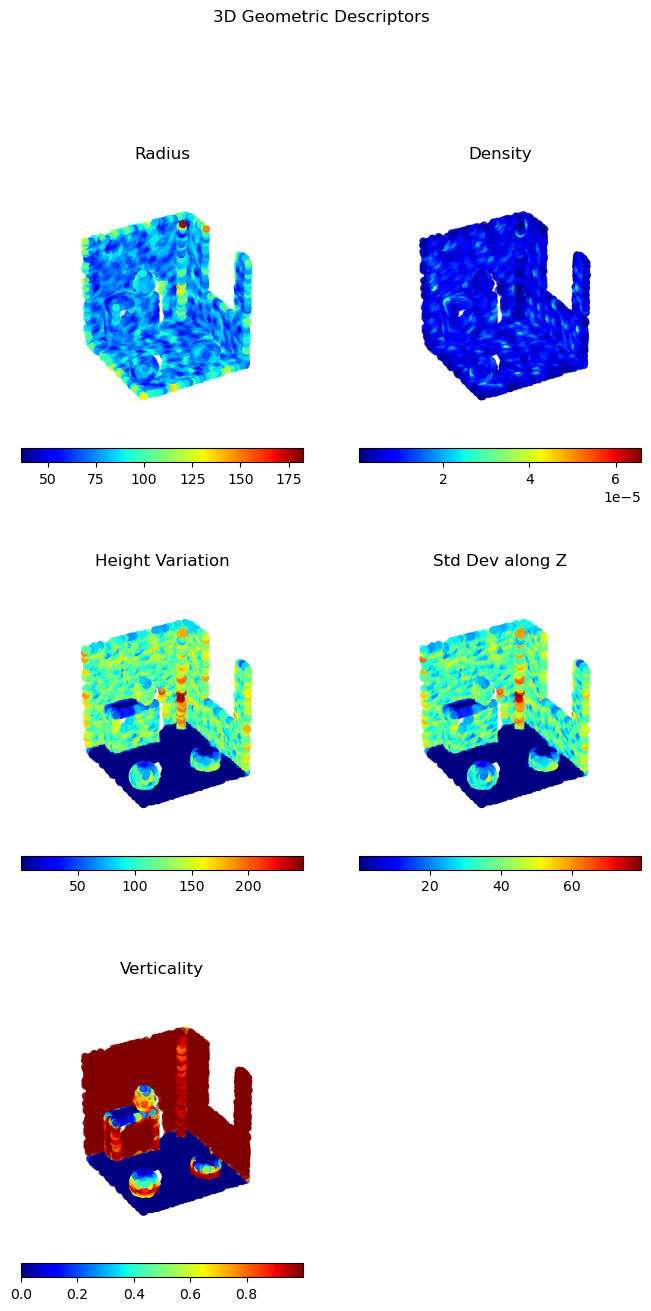

In [11]:
def compute_geometric_descriptor(points, neighbor_finding_function):
    """Compute 3D geometric descriptors: radius, density, height variation, and standard deviation along z."""
    
    dists, inds = neighbor_finding_function(points)
    k = inds.shape[1]  # number of neighbors (including the point itself)
    # Get the radius as the distance to the k-th nearest neighbor (distances are already sorted)
    radius = dists[:, -1]
    # Compute point density as number of neighbors divided by the volume of the sphere
    density = k / (4/3 * np.pi * radius**3)
    # Compute height variation along the z direction
    delta_z = np.ptp(points[inds, 2], axis=1)
    # Compute the standard deviation along the z direction
    std_z = np.std(points[inds, 2], axis=1)
    
    return radius, density, delta_z, std_z


def compute_verticality(normals):
    """Compute verticality descriptor."""
    # 1 - |nz| where nz is the z-component of the normal
    return 1 - np.abs(normals[:, 2])


# Compute geometric descriptors
neighbor_finding_function = lambda point: kdtree.query(point, k+1) # +1 because the point itself is included
radius, density, delta_z, std_z = compute_geometric_descriptor(points, neighbor_finding_function)
verticality = compute_verticality(oriented_normals)

# Visualize geometric descriptors
descriptors = {
    "Radius": radius,
    "Density": density,
    "Height Variation": delta_z,
    "Std Dev along Z": std_z,
    "Verticality": verticality
}
fig = plt.figure(figsize=(8, 15))
for i, (name, descriptor) in enumerate(descriptors.items()):
    ax = fig.add_subplot(3, 2, i+1, projection="3d")
    im = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=descriptor, cmap='jet')
    cbar = fig.colorbar(im, ax=ax, location="bottom", orientation="horizontal", pad=0)
    ax.set_title(name)
    plt.axis("equal")
    ax.view_init(30, 60)
    ax.set_axis_off()
plt.suptitle("3D Geometric Descriptors")
plt.show()


### Local 3D shape features

Linearity: $ L_{\lambda} = \frac{\lambda_1 - \lambda_2}{\lambda_1} $

Planarity: $ P_{\lambda} = \frac{\lambda_2 - \lambda_3}{\lambda_1} $

Scattering: $ S_{\lambda} = \frac{\lambda_3}{\lambda_1} $

Omnivariance: $ O_{\lambda} = (\lambda_1 \lambda_2 \lambda_3)^{\frac{1}{3}} $

Anisotropy: $ A_{\lambda} = \frac{\lambda_1 - \lambda_3}{\lambda_1} $

Eigenentropy: $ E_{\lambda} = -\lambda_1 \log(\lambda_1) - \lambda_2 \log(\lambda_2) - \lambda_3 \log(\lambda_3) $

Sum of Eigenvalues: $ \Sigma_{\lambda} = \lambda_1 + \lambda_2 + \lambda_3 $

Change of Curvature: $ C_{\lambda} = \frac{\lambda_3}{\lambda_1 + \lambda_2 + \lambda_3} $

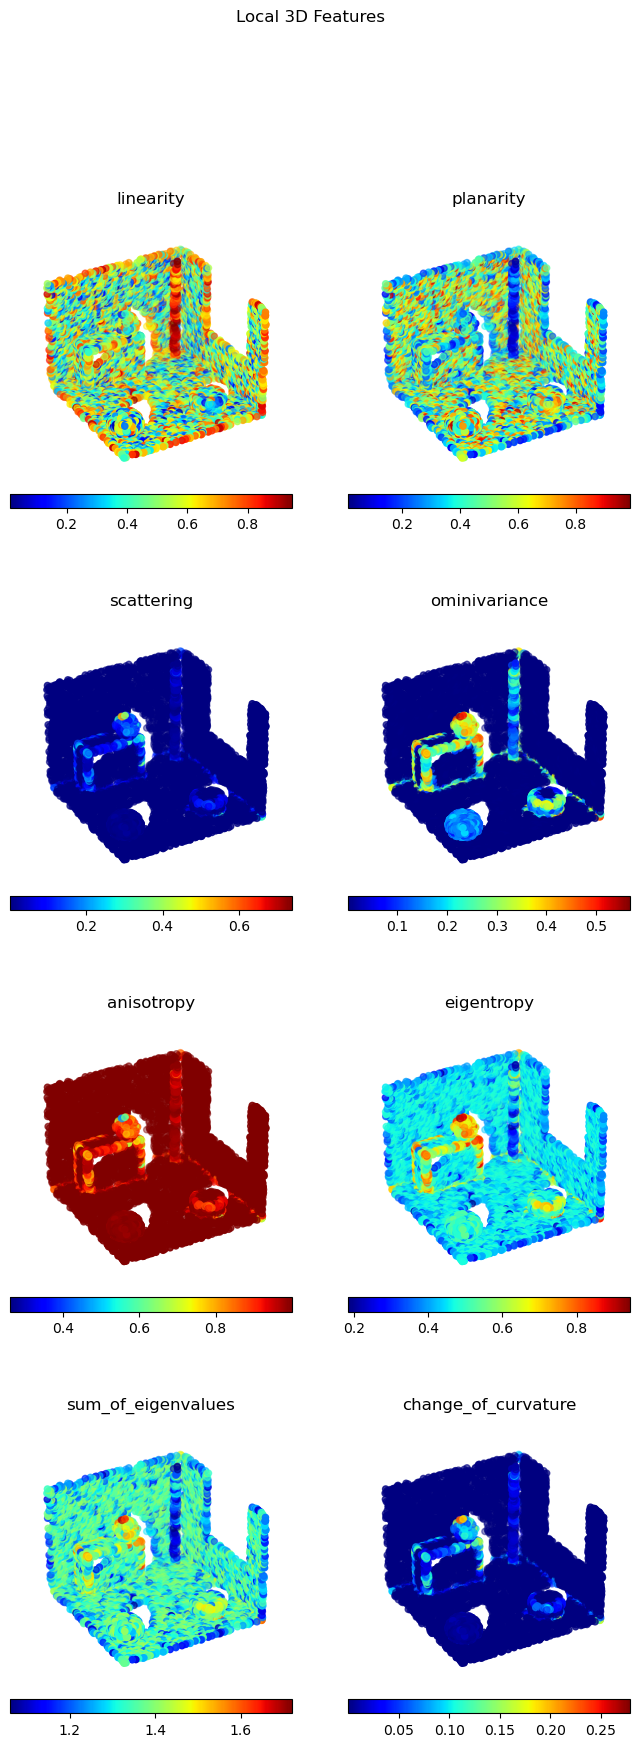

In [12]:
def compute_local_3d_features(points, neighbor_finding_function, norm_eigenvalues=False):
    """Compute local 3D features for each point in the point cloud."""
   
    features = {feature: np.zeros(points.shape[0]) for feature in ['linearity', 
        'planarity', 'scattering', 'ominivariance', 'anisotropy', 'eigentropy', 
        'sum_of_eigenvalues', 'change_of_curvature']}

    for i, point in enumerate(points):
        # Find the k nearest neighbors
        indices = neighbor_finding_function(point)
        # Get the neighbors
        neighbors = points[indices]
        # Compute the covariance matrix
        cov_matrix = np.cov(neighbors.T)
        # Compute the eigenvalues and eigenvectors
        eigenvalues, _ = np.linalg.eigh(cov_matrix)
        # Normalize eigenvalues if required
        if norm_eigenvalues:
            eigenvalues /= np.linalg.norm(eigenvalues)
        # Compute features based on eigenvalues
        features['linearity'][i] = (eigenvalues[2] - eigenvalues[1]) / eigenvalues[2]
        features['planarity'][i] = (eigenvalues[1] - eigenvalues[0]) / eigenvalues[2]
        features['scattering'][i] = eigenvalues[0] / eigenvalues[2]
        features['ominivariance'][i] = (eigenvalues[0] * eigenvalues[1] * eigenvalues[2]) ** (1/3)
        features['anisotropy'][i] = (eigenvalues[2] - eigenvalues[0]) / eigenvalues[2]
        features['eigentropy'][i] = -np.sum((eigenvalues) * np.log(eigenvalues) + 1e-10)
        features['sum_of_eigenvalues'][i] = np.sum(eigenvalues)
        features['change_of_curvature'][i] = eigenvalues[0] / np.sum(eigenvalues)

    return features


# Compute local 3D features
neighbor_finding_function = lambda point: kdtree.query(point, k+1)[1] # +1 because the point itself is included
local_3d_features = compute_local_3d_features(points, neighbor_finding_function, norm_eigenvalues=True)
# Visualize local 3D features
fig = plt.figure(figsize=(8, 20))
for i, (name, feature) in enumerate(local_3d_features.items()):
    ax = fig.add_subplot(4, 2, i+1, projection="3d")
    im = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=feature, cmap='jet')
    cbar = fig.colorbar(im, ax=ax, location="bottom", orientation="horizontal", pad=0)
    ax.set_title(name)
    ax.view_init(30, 60)
    ax.set_axis_off()
plt.suptitle("Local 3D Features")
plt.show()


## 2D features

Radius of k-Nearest Neighbors in 2D: The maximum distance in the XY plane to the ( k )-th nearest neighbor.

Density in 2D: $D_{2D} = \frac{k+1}{\pi r{\text{2D}}^2} $ where $r_{2D}$ is the radius in the XY plane.

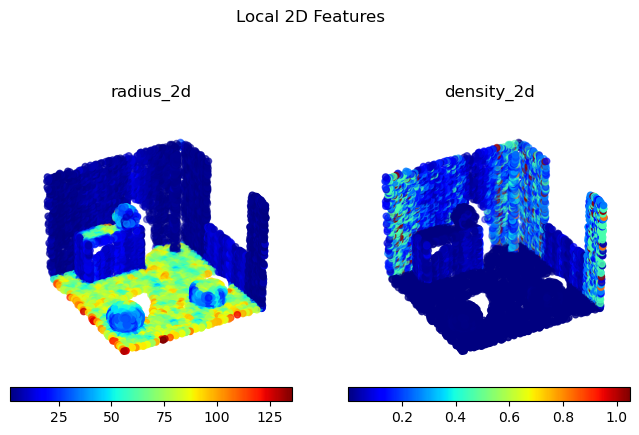

In [17]:
def compute_2d_descriptors(points, neighbor_finding_function):
    """Compute local 2D features for each point in the point cloud."""
   
    features = {feature: np.zeros(points.shape[0]) for feature in ["radius_2d", "density_2d"]}
    
    for i, point in enumerate(points):
        # Find the k nearest neighbors
        dists, _ = neighbor_finding_function(point)
        k = len(dists)  # number of neighbors (including the point itself)
        # Get the radius as the distance to the k-th nearest neighbor (distances are already sorted)
        radius = dists[-1]
        features['radius_2d'][i] = radius
        # Compute 2D density
        area = np.pi * (radius ** 2)
        #area = np.pi * (np.max(np.linalg.norm(neighbors_xy - point[:2], axis=1)) ** 2)
        features['density_2d'][i] = k / area

    return features


# Compute local 2D features
points_xy = points[:, :2]
kdtree_2d = KDTree(points_xy)
neighbor_finding_function = lambda point_xy: kdtree_2d.query(point_xy, k+1) # +1 because the point itself is included
local_2d_features = compute_2d_descriptors(points_xy, neighbor_finding_function)

# Visualize local 2D features
fig = plt.figure(figsize=(8, 5))
for i, (name, feature) in enumerate(local_2d_features.items()):
    ax = fig.add_subplot(1, 2, i+1, projection="3d")
    im = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=feature, cmap='jet')
    cbar = fig.colorbar(im, ax=ax, location="bottom", orientation="horizontal", pad=0)
    #cbar.set_label(name)
    ax.set_title(name)
    ax.view_init(30, 60)
    ax.set_axis_off()
plt.suptitle("Local 2D Features")
plt.show()


Sum of Eigenvalues in 2D: $\Sigma_{\lambda, 2D} = \lambda_{1, 2D} + \lambda_{2,2D}$

Eigenvalue Ratio in 2D: $R_{\lambda, 2D} = \frac{\lambda{2,\text{2D}}}{\lambda_{1,\text{2D}}}$

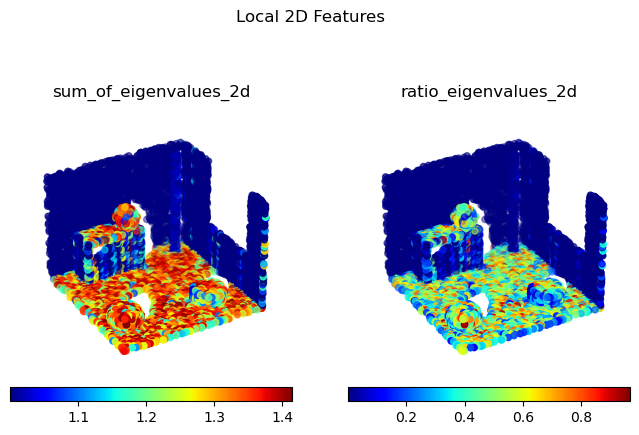

In [14]:
def compute_local_2d_features(points, neighbor_finding_function, norm_eigenvalues=False):
    """Compute local 2D features for each point in the point cloud."""
   
    features = {feature: np.zeros(points.shape[0]) for feature in ["sum_of_eigenvalues_2d",
        "ratio_eigenvalues_2d"]}
    
    for i, point in enumerate(points):
        # Find the k nearest neighbors
        _, indices = neighbor_finding_function(point)
        # Get the neighbors
        neighbors = points[indices]
        # Compute the covariance matrix
        cov_matrix = np.cov(neighbors.T)
        # Compute the eigenvalues and eigenvectors
        eigenvalues, _ = np.linalg.eigh(cov_matrix)
        # Normalize eigenvalues if required
        if norm_eigenvalues:
            eigenvalues /= np.linalg.norm(eigenvalues)
        # Compute features based on eigenvalues
        features['sum_of_eigenvalues_2d'][i] = np.sum(eigenvalues)
        features['ratio_eigenvalues_2d'][i] = eigenvalues[0] / (eigenvalues[1] + 1e-10)

    return features


# Compute local 2D features
local_2d_features = compute_local_2d_features(points_xy, neighbor_finding_function, norm_eigenvalues=True)

# Visualize local 2D features
fig = plt.figure(figsize=(8, 5))
for i, (name, feature) in enumerate(local_2d_features.items()):
    ax = fig.add_subplot(1, 2, i+1, projection="3d")
    im = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=feature, cmap='jet')
    cbar = fig.colorbar(im, ax=ax, location="bottom", orientation="horizontal", pad=0)
    ax.set_title(name)
    ax.view_init(30, 60)
    ax.set_axis_off()
plt.suptitle("Local 2D Features")
plt.show()


Frequency Accumulation Map: The number of points within each raster cell.

Delta Z in Raster Cells: $\Delta Z = \max(Z_{\text{cell}}) - \min(Z_{\text{cell}})$

Standard Deviation of Z in Raster Cells: $\text{Std Z}{\text{cell}} = \sqrt{\frac{1}{n} \sum{j=1}^{n} (Z_j - \bar{Z}_{\text{cell}})^2}$

## Wrapping up

You should now have a better grasp of how to extract local geometrical information from pointclouds. These are particularly useful for "traditional" tasks such as surface reconstruction and segmentation, but also enablers for machine learning enabling tasks such as classification, discussed in the next notebook.
